In [68]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Download stopwords if not already downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wilsonflores/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [69]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hassanamin/textdb3")

print("Path to dataset files:", path)

Path to dataset files: /Users/wilsonflores/.cache/kagglehub/datasets/hassanamin/textdb3/versions/1


In [70]:
df = pd.read_csv(path + "/fake_or_real_news.csv")
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [71]:
# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/fake-news-detection")

print("Path to dataset files:", path)

Path to dataset files: /Users/wilsonflores/.cache/kagglehub/datasets/bhavikjikadara/fake-news-detection/versions/1


In [72]:
df2true = pd.read_csv(path + "/true.csv")
df2true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [73]:
df2fake = pd.read_csv(path + "/fake.csv")
df2fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [74]:
df2true = df2true.drop(columns=['subject', 'date'])
df2fake = df2fake.drop(columns=['subject', 'date'])

In [75]:
df2true.head()

,title,text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...


In [76]:
df2fake.head()


,title,text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...


In [77]:
# Add a label column to each dataframe
df2fake['label'] = 1  # Label for fake news
df2true['label'] = 0  # Label for true news

# Combine the two dataframes
df2trueandfake = pd.concat([df2fake, df2true], ignore_index=True)
df2trueandfake.head()

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1


In [78]:
df2trueandfake.shape

(44898, 3)

In [79]:
df2trueandfake['combined'] = df2trueandfake['title'] + " " + df2trueandfake['text']
df2trueandfake.head()

,title,text,label,combined
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",1,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",1,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1,Pope Francis Just Called Out Donald Trump Dur...


In [80]:
df2trueandfake = df2trueandfake.drop(columns=['title', 'text'])
df2trueandfake.head()

,label,combined
0,1,Donald Trump Sends Out Embarrassing New Year’...
1,1,Drunk Bragging Trump Staffer Started Russian ...
2,1,Sheriff David Clarke Becomes An Internet Joke...
3,1,Trump Is So Obsessed He Even Has Obama’s Name...
4,1,Pope Francis Just Called Out Donald Trump Dur...


In [81]:
# Download latest version
path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/wilsonflores/.cache/kagglehub/datasets/saurabhshahane/fake-news-classification/versions/77


In [82]:
df3 = pd.read_csv(path + "/WELFake_Dataset.csv")

In [83]:
df3

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [84]:
df3 = df3.drop(columns=['Unnamed: 0'])
df3.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [85]:
# Combining title and text columns
df3['combined'] = df3['title'] + " " + df3['text']
df3.head()

,title,text,label,combined
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1,NaN,Did they post their votes for Hillary already?,1,NaN
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...


In [86]:
df3 = df3.drop(columns=['title', 'text'])
df3.head()

,label,combined
0,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1,1,NaN
2,1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,1,SATAN 2: Russia unvelis an image of its terrif...


In [87]:
df3 = df3.dropna()
df3.head()

,label,combined
0,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
2,1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,1,SATAN 2: Russia unvelis an image of its terrif...
5,1,About Time! Christian Group Sues Amazon and SP...


In [88]:
# df3['label'] = df3['label'].apply(lambda x: 0 if x == 1 else 1)
# df3.head()

In [89]:
# Combining title and text columns
df['combined'] = df['title'] + " " + df['text']
df.head()

,Unnamed: 0,title,text,label,combined
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy U....
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,Bernie supporters on Twitter erupt in anger ag...
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,The Battle of New York: Why This Primary Matte...


In [90]:
# Dropping the original title and text columns
df = df.drop(columns=['title', 'text'])
df.head()

,Unnamed: 0,label,combined
0,8476,FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...
1,10294,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...
2,3608,REAL,Kerry to go to Paris in gesture of sympathy U....
3,10142,FAKE,Bernie supporters on Twitter erupt in anger ag...
4,875,REAL,The Battle of New York: Why This Primary Matte...


In [91]:
# Dropping the index column
df = df.drop(columns=['Unnamed: 0'])
df.head()

,label,combined
0,FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...
1,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...
2,REAL,Kerry to go to Paris in gesture of sympathy U....
3,FAKE,Bernie supporters on Twitter erupt in anger ag...
4,REAL,The Battle of New York: Why This Primary Matte...


In [92]:
# Renaming label values
df['label'] = df['label'].replace({'FAKE': 1, 'REAL': 0})
df.head()

/var/folders/l_/lf6d8099353513n02jjnblsw0000gn/T/ipykernel_20289/1320685171.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace({'FAKE': 1, 'REAL': 0})


,label,combined
0,1,You Can Smell Hillary’s Fear Daniel Greenfield...
1,1,Watch The Exact Moment Paul Ryan Committed Pol...
2,0,Kerry to go to Paris in gesture of sympathy U....
3,1,Bernie supporters on Twitter erupt in anger ag...
4,0,The Battle of New York: Why This Primary Matte...


In [93]:
df = pd.concat([df, df2trueandfake], ignore_index=True)
df.head()

,label,combined
0,1,You Can Smell Hillary’s Fear Daniel Greenfield...
1,1,Watch The Exact Moment Paul Ryan Committed Pol...
2,0,Kerry to go to Paris in gesture of sympathy U....
3,1,Bernie supporters on Twitter erupt in anger ag...
4,0,The Battle of New York: Why This Primary Matte...


In [94]:
df = pd.concat([df, df3], ignore_index=True)
df.head()

,label,combined
0,1,You Can Smell Hillary’s Fear Daniel Greenfield...
1,1,Watch The Exact Moment Paul Ryan Committed Pol...
2,0,Kerry to go to Paris in gesture of sympathy U....
3,1,Bernie supporters on Twitter erupt in anger ag...
4,0,The Battle of New York: Why This Primary Matte...


In [95]:
df.shape

(122770, 2)

In [96]:
# Dropping rows with missing values
df = df.dropna()
df.head()

,label,combined
0,1,You Can Smell Hillary’s Fear Daniel Greenfield...
1,1,Watch The Exact Moment Paul Ryan Committed Pol...
2,0,Kerry to go to Paris in gesture of sympathy U....
3,1,Bernie supporters on Twitter erupt in anger ag...
4,0,The Battle of New York: Why This Primary Matte...


In [97]:
# Removing punctuation
import string

df['combined'] = df['combined'].str.replace(f"[{string.punctuation}]", "", regex=True)
df.head()

,label,combined
0,1,You Can Smell Hillary’s Fear Daniel Greenfield...
1,1,Watch The Exact Moment Paul Ryan Committed Pol...
2,0,Kerry to go to Paris in gesture of sympathy US...
3,1,Bernie supporters on Twitter erupt in anger ag...
4,0,The Battle of New York Why This Primary Matter...


In [98]:
# Making all text lowercase
df['combined'] = df['combined'].str.lower()
df.head()

,label,combined
0,1,you can smell hillary’s fear daniel greenfield...
1,1,watch the exact moment paul ryan committed pol...
2,0,kerry to go to paris in gesture of sympathy us...
3,1,bernie supporters on twitter erupt in anger ag...
4,0,the battle of new york why this primary matter...


In [99]:
# stemming words

# Initialize the PorterStemmer
stemmer = PorterStemmer()

# Apply stemming to the 'combined' column
df['combined'] = df['combined'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
df.head()

,label,combined
0,1,you can smell hillary’ fear daniel greenfield ...
1,1,watch the exact moment paul ryan commit polit ...
2,0,kerri to go to pari in gestur of sympathi us s...
3,1,berni support on twitter erupt in anger agains...
4,0,the battl of new york whi thi primari matter i...


In [100]:
df['combined'] = df['combined'].str.replace("'", "", regex=False)
df.head()

,label,combined
0,1,you can smell hillary’ fear daniel greenfield ...
1,1,watch the exact moment paul ryan commit polit ...
2,0,kerri to go to pari in gestur of sympathi us s...
3,1,berni support on twitter erupt in anger agains...
4,0,the battl of new york whi thi primari matter i...


In [101]:
# Removing curly apostrophe
df['combined'] = df['combined'].str.replace("’", "", regex=False)
df.head()

,label,combined
0,1,you can smell hillary fear daniel greenfield a...
1,1,watch the exact moment paul ryan commit polit ...
2,0,kerri to go to pari in gestur of sympathi us s...
3,1,berni support on twitter erupt in anger agains...
4,0,the battl of new york whi thi primari matter i...


In [102]:
# Removing stopwords
# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from the 'combined' column
df['combined'] = df['combined'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df.head()

,label,combined
0,1,smell hillary fear daniel greenfield shillman ...
1,1,watch exact moment paul ryan commit polit suic...
2,0,kerri go pari gestur sympathi us secretari sta...
3,1,berni support twitter erupt anger dnc tri warn...
4,0,battl new york whi thi primari matter primari ...


In [103]:
X = df['combined']
y = df['label']

In [104]:
# X: feature matrix, y: target vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [105]:
# View training and testing data
print("Training data:")
print(X_train.shape)
print(y_train.shape)
print("Testing data:")
print(X_test.shape)
print(y_test.shape)

Training data:
(98216,)
(98216,)
Testing data:
(24554,)
(24554,)


In [106]:
y_train.value_counts()

label
1    50541
0    47675
Name: count, dtype: int64

In [107]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [ ]:
# Define the model
model = Sequential()

# Input layer
model.add(Dense(128, input_dim=X_train_tfidf.shape[1], activation='relu'))

# Hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_tfidf, y_train, epochs=20, batch_size=32, validation_split=0.2, shuffle=True)

# Summary of the model
# model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9235 - loss: 0.2055 - val_accuracy: 0.9695 - val_loss: 0.0838
Epoch 2/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9801 - loss: 0.0571 - val_accuracy: 0.9791 - val_loss: 0.0649
Epoch 3/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9936 - loss: 0.0203 - val_accuracy: 0.9828 - val_loss: 0.0641
Epoch 4/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9978 - loss: 0.0075 - val_accuracy: 0.9841 - val_loss: 0.0805
Epoch 5/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9990 - loss: 0.0034 - val_accuracy: 0.9843 - val_loss: 0.0908
Epoch 6/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9992 - loss: 0.0018 - val_accuracy: 0.9834 - val_loss: 0.1128
Epoch 7/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9992 - loss: 0.0028 - val_accuracy: 0.9836 - val_loss: 0.1088
Epoch 8/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9994 - loss: 0.0015 - 

In [109]:
# Transform X_test using the trained TfidfVectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_tfidf, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.9832 - loss: 0.2055
Test Loss: 0.2074745148420334
Test Accuracy: 0.9826504588127136


768/768 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step


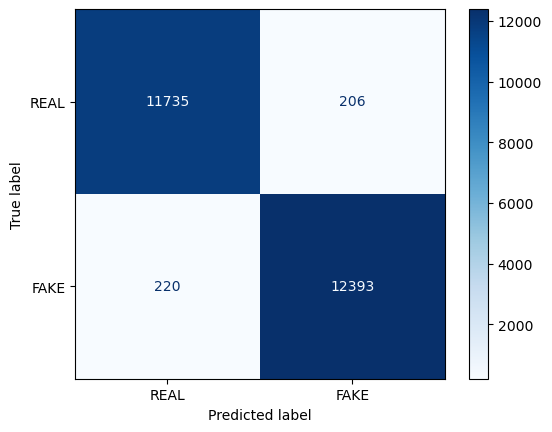

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the labels for the test set
y_pred = (model.predict(X_test_tfidf) > 0.5).astype("int32")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['REAL', 'FAKE'])
disp.plot(cmap='Blues')

In [111]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=['REAL', 'FAKE'])

# Print the report
print(report)

              precision    recall  f1-score   support

        REAL       0.98      0.98      0.98     11941
        FAKE       0.98      0.98      0.98     12613

    accuracy                           0.98     24554
   macro avg       0.98      0.98      0.98     24554
weighted avg       0.98      0.98      0.98     24554

